# Network Science: resilience of a network under targeted attacks

## Description:

Study the resilience against targeted attack of real networks! Apply
removal processes where the removal order of the nodes depends on
different centralities: the degree, the betweenness, PageRank, etc.,
and compare the results. Analyse the problem of resilience on the
corresponding random graphs as well. Use an ensemble of E-R graphs
and also randomized networks with preserved degree distribution.

Plot the relative size of the largest connected component as a function
of the removed fraction of nodes. Since we are interested in whether we
see a phase transition like disassembly of the network or not, plot also
the quantity corresponding to the susceptibility, $$χ=\frac{\sum_{\alpha}N^2_{\alpha}}{N^2}$$, where α
runs over the connected components except for the largest one, and
Nα denotes the number of nodes in the given component

### Relevant literature:

https://arxiv.org/ftp/arxiv/papers/1312/1312.3139.pdf  
https://arxiv.org/ftp/arxiv/papers/1508/1508.03542.pdf  
https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0205-5  
https://arxiv.org/pdf/2003.05303.pdf  

## Identified key parts:

#### 1. What is resilience, and what metrics can we define in a network context?
#### 2. How can we decide on the most relevant nodes to remove?
#### 3. Which graphs are we using to test our algorithms?

## What is the resilience of a network?

The resilience of a system is the ability to provide and maintain an acceptable level of service in the face of faults and challenges to normal operation. 

From a network science point of view we can see the fault as node removal and the normal operation as how well is connected the system through some specific metrics.  
<img src='https://drive.google.com/uc?id=1xSVSrOpFMhZ7eFV_v5tezQyrleYGTLgs'>

The aim of this notebook is to study the performance of a set of networks against the targeted attack according to different metrics. We construct an alogrithm to iteratively remove batches of nodes from different types of graphs until they are empty while evaluating the resiliance of it. Finally, we analyze this data and compare the results.

## How do we measure resilience?

In order to evaluate the resilience of a network we identify three main metrics used in the literature:

- Density: the most naive approach. We divide the number of existing connections in the network over the number of potential connections.  
$$D= \frac{E}{E_{max}}$$
- Largest Connected Component (LCC): the number of nodes contained in the biggest connected set of the network. Instead of the absolute value, we will use the size relative to the initial LCC of the network.  
$$LCC_{rel} = 1 - \frac{LCC - LCC_{init}}{LCC_{init}}$$
- Susceptibility: represents the rest of the components by adding the squared value of the number of nodes of every component except the largest. This represents how sensitive is the system to perturbations.  
$$S=\frac{(\sum_{\beta \in C}N_{C}^2) - LCC^2}{N^2}$$  

## What removal methods can we define?

We can test different metrics of the network to form our removal order. These give us the possibility to understand better under which attacks is the network more unstable.  

The metrics that we use are the following:

*   **Eigenvector centrality** is a measure of the influence of a node in the network. Each node has a score and his node depend on the neigbhoor's score.
*   **Triangles** is a centrality where the count value is the number of triangles that the node forms.
*   **Betweenness centrality** is a metric based on the shortest path. For each node we calculate the number of times that it is part of a shortest path.
*   **Closeness centrality** measures the average farness (inverse distance) of a node to all the others. Nodes with a high closeness score have the shortest distances to all other nodes.
*   **PageRank**, created and used by Google to give a priority value to a webpage. The value depends on the number of neighbours and their recursive value.
*   **Degree** of a node is its number of neigbours.
*   **Clustering** of a node is the division between the number of effective and potential connection of its neighbours.  

We will also use random selection to compare the obtained results.

## Implementation

#### Import used libraries

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline

import networkx
from networkx import nx

from scipy.io import mmread

import time
import signal
import os
import errno
from functools import wraps
from copy import deepcopy
import random

#### Generated Random Networks  

For each of the random models, we will define a grid of hyperparameters that will allow us to construct a matrix of graphs in order to test on multiple sizes and densities. After constructing the graphs, we will randomize them preserving the degree distribution using the configuration model.

In [2]:
SEED = 101

In [3]:
# Helper code for later

class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

##### Erdös-Rényi model
Providing the number of nodes and the probability of a connection as hyperparameters.

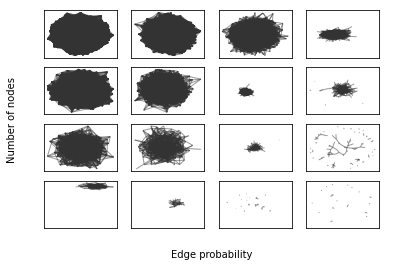

In [4]:
# Ensemble of ER Graphs with preserved degree distribution.

n_list = [100, 250, 500, 1000]  # number of nodes
p_list = [0.005, 0.01, 0.025, 0.05]  # probability of an edge

er_graphs = []

for n in n_list:
    for p in p_list:
        G = nx.erdos_renyi_graph(n, p, seed=SEED)
        G.graph['n'] = n
        G.graph['p'] = p

        degree_sequence = dict(nx.degree(G)).values()
        # Generate a random network with the same node degrees
        G_configuration = nx.degree_seq.configuration_model(degree_sequence)

        er_graphs.append(G_configuration)
        

rows = len(n_list)
cols = len(p_list)
        
fig, ax = plt.subplots(rows, cols)

# wrapper subplot for the common labels
fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Edge probability')
plt.ylabel('Number of nodes')

pos = None
for i, G in enumerate(er_graphs):
    # Calculate the layout
    pos = nx.spring_layout(G, pos=pos, k=0.09)
    r = rows-int(i/rows)-1
    c = cols-(i%cols)-1
    plt.sca(ax[r][c])
    
    nx.draw_networkx(G, pos=pos, alpha=0.5, edge_color='#333333', node_size=0, with_labels=False)


plt.show()

##### Barabási-Albert model
Providing the number of nodes and the number of edges represented as a percentage of the number of nodes, in order to fit the parameters similarly to the previous models.

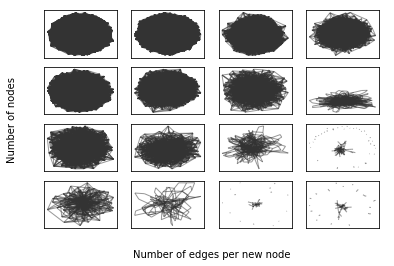

In [5]:
# Ensemble of BA Graphs with preserved degree distribution.

n_list = [100, 250, 500, 1000]  # number of nodes
m_list = [0.005, 0.01, 0.025, 0.05]  # number of edges represented as a percentage of the number of nodes

ba_graphs = []

for n in n_list:
    for m in m_list:
        G = nx.barabasi_albert_graph(n,max(1, int(m*n)), seed=SEED)
        G.graph['n'] = n
        G.graph['m'] = m

        degree_sequence = dict(nx.degree(G)).values()
        # Generate a random network with the same node degrees
        G_configuration = nx.degree_seq.configuration_model(degree_sequence)

        ba_graphs.append(G_configuration)
        

rows = len(n_list)
cols = len(m_list)
        
fig, ax = plt.subplots(rows, cols)

# wrapper subplot for the common labels
fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Number of edges per new node')
plt.ylabel('Number of nodes')

pos = None
for i, G in enumerate(ba_graphs):
    # Calculate the layout
    pos = nx.spring_layout(G, pos=pos, k=0.09)
    r = rows-int(i/rows)-1
    c = cols-(i%cols)-1
    plt.sca(ax[r][c])
    
    nx.draw_networkx(G, pos=pos, alpha=0.5, edge_color='#333333', node_size=0, with_labels=False)


plt.show()

##### Watts Strogatz model
Providing the number of nodes and the number of neighbours as a percentage of the number of nodes, in order to fit the parameters similarly to the previous models.

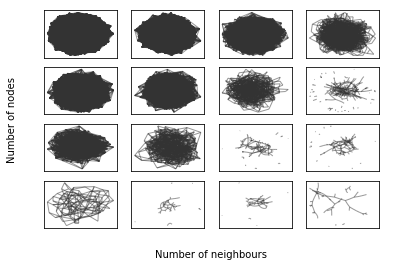

In [6]:
# Ensemble of WS Graphs with preserved degree distribution.

n_list = [100, 250, 500, 1000]  # number of nodes
k_list = [0.005, 0.01, 0.025, 0.05]  # number of neighbours as a percentage of the number of nodes
p = 0.5 # probability of rewiring a node

ws_graphs = []

for n in n_list:
    for k in k_list:
        G = nx.watts_strogatz_graph(n, max(2, int(k*n)), p, seed=SEED)
        G.graph['n'] = n
        G.graph['k'] = k
        G.graph['p'] = p
        
        degree_sequence = dict(nx.degree(G)).values()
        # Generate a random network with the same node degrees
        G_configuration = nx.degree_seq.configuration_model(degree_sequence)

        ws_graphs.append(G_configuration)
        

rows = len(n_list)
cols = len(k_list)
        
fig, ax = plt.subplots(rows, cols)

# wrapper subplot for the common labels
fig.add_subplot(111, frameon=False)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Number of neighbours')
plt.ylabel('Number of nodes')

pos = None
for i, G in enumerate(ws_graphs):
    # Calculate the layout
    pos = nx.spring_layout(G, pos=pos, k=0.09)
    r = rows-int(i/rows)-1
    c = cols-(i%cols)-1
    plt.sca(ax[r][c])
    
    nx.draw_networkx(G, pos=pos, alpha=0.5, edge_color='#333333', node_size=0, with_labels=False)


plt.show()

#### Used Real Networks:

##### RoadNet, road data from California. DISCARDED FOR THE ANALYSIS, NETWORK SIZE TOO LARGE

In [7]:
# Road data from California: https://snap.stanford.edu/data/roadNet-CA.html

#g_roadNet_CA = nx.read_adjlist("data/roadNet-CA.txt")


# too big to use :(

##### Gnutella, internet data from a file sharing network from August 2002.

In [8]:
# Internet data from Gnutella peer-to-peer file sharing network from August 2002 https://snap.stanford.edu/data/p2p-Gnutella08.html

g_gnutella = nx.read_adjlist("data/p2p-Gnutella08.txt")

print("Number of nodes:",nx.number_of_edges(g_gnutella))
print("Number of edges:",nx.number_of_nodes(g_gnutella))
print("Average degree:",nx.number_of_edges(g_gnutella)/nx.number_of_nodes(g_gnutella))

Number of nodes: 20777
Number of edges: 6301
Average degree: 3.2974131090303125


##### Power Network, data from the electricity grid.

In [9]:
# Power Network http://networkrepository.com/power.php

g_power = mmread('data/power-1138-bus.mtx')

g_power = nx.from_scipy_sparse_matrix(g_power)

print("Number of nodes:",nx.number_of_edges(g_power))
print("Number of edges:",nx.number_of_nodes(g_power))
print("Average degree:",nx.number_of_edges(g_power)/nx.number_of_nodes(g_power))

Number of nodes: 2596
Number of edges: 1138
Average degree: 2.281195079086116


##### Roads of Minnesota, road data from Minnesota.

In [10]:
# Road Minnesota http://networkrepository.com/road.php

g_roads_minnesota = mmread('data/road-minnesota.mtx')

g_roads_minnesota = nx.from_scipy_sparse_matrix(g_roads_minnesota)

print("Number of nodes:",nx.number_of_edges(g_roads_minnesota))
print("Number of edges:",nx.number_of_nodes(g_roads_minnesota))
print("Average degree:",nx.number_of_edges(g_roads_minnesota)/nx.number_of_nodes(g_roads_minnesota))

Number of nodes: 3303
Number of edges: 2642
Average degree: 1.2501892505677517


##### OpenFlights, representing airports and the number of routes according to their weights.

In [11]:
# The weights in this network refer to the number of routes between two airports. http://networkrepository.com/bn.php

g_openflights = nx.read_adjlist("data/inf-openflights.edges")

print("Number of nodes:",nx.number_of_edges(g_openflights))
print("Number of edges:",nx.number_of_nodes(g_openflights))
print("Average degree:",nx.number_of_edges(g_openflights)/nx.number_of_nodes(g_openflights))

Number of nodes: 15682
Number of edges: 2943
Average degree: 5.328576282704723


##### Drosophilia, edges represent fiber tracts that connect one vertex to another.

In [12]:
# Edges represent fiber tracts that connect one vertex to another http://networkrepository.com/bn-fly-drosophila-medulla-1.php

g_drosophilia = nx.read_adjlist("data/bn-fly-drosophila_medulla_1.edges")

print("Number of nodes:",nx.number_of_edges(g_drosophilia))
print("Number of edges:",nx.number_of_nodes(g_drosophilia))
print("Average degree:",nx.number_of_edges(g_drosophilia)/nx.number_of_nodes(g_drosophilia))

Number of nodes: 9016
Number of edges: 1781
Average degree: 5.0623245367770915


#### Visualising one of the real networks and its degree distribution:

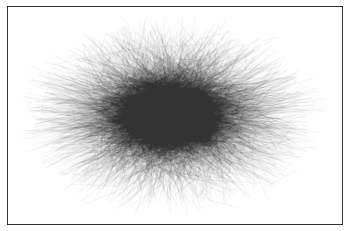

In [13]:
# Calculate layout and draw
pos = nx.spring_layout(g_gnutella, k=0.1)
nx.draw_networkx(
    g_gnutella, pos=pos, node_size=0, edge_color="#333333", alpha=0.05, with_labels=False)

In [14]:
# our algorithms for in/outdegree
indegree_map = {node:0 for node in g_gnutella.nodes()}
for source,target in g_gnutella.edges():
    indegree_map[target] += 1

outdegree_map = {node:0 for node in g_gnutella.nodes()}
for source,target in g_gnutella.edges():
    outdegree_map[source] += 1

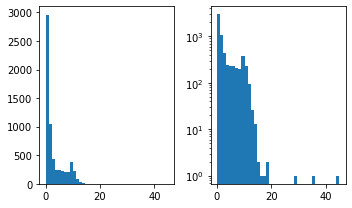

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

axes[0].hist(indegree_map.values(), bins=40)
axes[1].hist(indegree_map.values(), bins=40, log=True)

fig.tight_layout()

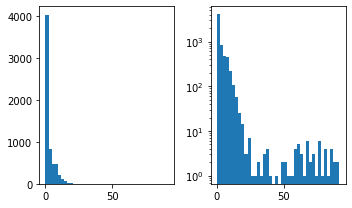

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

axes[0].hist(outdegree_map.values(), bins=40)
axes[1].hist(outdegree_map.values(), bins=40, log=True)

fig.tight_layout()

#### Measuring Resilience:

###### Density as defined by networkx:

In [17]:
import networkx.algorithms.connectivity as nxcon

'''
print("Minimum node cut:",nxcon.minimum_node_cut(er_graphs[7])) # only for connected networks
print("Minimum edge cut:",nxcon.minimum_edge_cut(er_graphs[7])) # only for connected networks
print("Node connectivity:",nx.node_connectivity(er_graphs[7])) # only for connected networks
print("Average node connectivity:",nx.average_node_connectivity(er_graphs[7])) # only for connected networks
'''
# simplest measure of resilience: density
print("Density:",nx.density(g_gnutella))

Density: 0.0010467978123905755


##### Absolute LCC:

In [18]:
def lcc_size(graph):
    compsize = []
    for c in nx.connected_components(graph):
        compsize.append(nx.number_of_nodes(graph.subgraph(c)))
    return max(compsize)

##### Relative LCC:

In [19]:
#@timeout(5)
def compute_resilience(graph, lccinit):
  '''
  As defined in Cavallaro et al in this paper: https://arxiv.org/pdf/2003.05303.pdf
  '''
  return 1 - (abs((lcc_size(graph) - lccinit) / lccinit))

##### Susceptibility:

In [20]:
def susceptibility(graph):
    compsize = []
    for c in nx.connected_components(graph):
        compsize.append(nx.number_of_nodes(graph.subgraph(c)))
    
    return (sum([number ** 2 for number in compsize])-max(compsize)**2)/(sum(compsize))**2

#### Removal Order:

###### Betweenness centrality:

In [21]:
# Using k=myk argument to get an approximation for the huge CA graph
# Betweenness centrality is a slow calculation. 
# The algorithm used by networkx is O(VE) where V is the number of vertices and E the number of edges
# source: https://stackoverflow.com/questions/32465503/networkx-never-finishes-calculating-betweenness-centrality-for-2-mil-nodes


start_time = time.time()

# for roadNet k = 10 it takes 228 seconds, don't think it is feasible...
# for Gnutella, the regular method takes 350 seconds.

betweenness = nx.betweenness_centrality(g_gnutella, normalized=False)
#sorted(betweenness.items(), key=lambda x:x[1], reverse=True)[0:10]

print("--- %s seconds ---" % (time.time() - start_time))

--- 332.8339011669159 seconds ---


###### Betweenness centrality approximation with a 1% sample:

In [22]:
# Using k=myk argument to get an approximation for the huge CA graph
# Betweenness centrality is a slow calculation. 
# The algorithm used by networkx is O(VE) where V is the number of vertices and E the number of edges
# source: https://stackoverflow.com/questions/32465503/networkx-never-finishes-calculating-betweenness-centrality-for-2-mil-nodes

start_time = time.time()

# for roadNet k = 10 it takes 228 seconds, don't think it is feasible...
# for Gnutella, the regular method takes 350 seconds.

K = int(nx.number_of_nodes(g_gnutella) * 0.01)

betweenness = nx.betweenness_centrality(g_gnutella, k=K, normalized=False)
betweness_sorted = sorted(betweenness.items(), key=lambda x:x[1], reverse=True)[0:10]

print("--- %s seconds ---" % (time.time() - start_time))

--- 3.351853370666504 seconds ---


###### Betweenness centrality approximation with a 1% sample:

In [23]:
# Using k=myk argument to get an approximation for the huge CA graph
# Betweenness centrality is a slow calculation. 
# The algorithm used by networkx is O(VE) where V is the number of vertices and E the number of edges
# source: https://stackoverflow.com/questions/32465503/networkx-never-finishes-calculating-betweenness-centrality-for-2-mil-nodes

start_time = time.time()

# for roadNet k = 10 it takes 228 seconds, don't think it is feasible...
# for Gnutella, the regular method takes 350 seconds.

K = int(nx.number_of_nodes(g_gnutella) * 0.1)

betweenness = nx.betweenness_centrality(g_gnutella, k=K, normalized=False)
sorted(betweenness.items(), key=lambda x:x[1], reverse=True)[0:10]

print("--- %s seconds ---" % (time.time() - start_time))

--- 33.011075258255005 seconds ---


###### Eigenvector centrality:

In [24]:
# using scipy.sparse instead of nx.eigenvector_centrality for large graphs
# source: https://stackoverflow.com/questions/56707517/fast-calculation-of-eigenvector-centrality-takes-too-long-in-networkx

import scipy.sparse as sparse

start_time = time.time()

#vals, vecs = sparse.linalg.eigs(nx.to_numpy_matrix(g_gnutella), k=1, which='LM')
eigenvectors = nx.eigenvector_centrality(g_gnutella)
print(sorted(eigenvectors.items(), key=lambda x:x[1], reverse=True)[0:10])

print("--- %s seconds ---" % (time.time() - start_time))

[('367', 0.1595869633613528), ('123', 0.15231205152783914), ('145', 0.13988740713526301), ('249', 0.13724405403067433), ('5', 0.1346282117747854), ('127', 0.13315580396804827), ('353', 0.130087851377089), ('427', 0.1293257741253371), ('124', 0.1289917037789116), ('149', 0.128130311810794)]
--- 0.5689232349395752 seconds ---


###### Closeness centrality:

In [25]:
start_time = time.time()

closeness = nx.closeness_centrality(g_gnutella)
sorted(closeness.items(), key=lambda x:x[1], reverse=True)[0:10]

print("--- %s seconds ---" % (time.time() - start_time))

--- 95.3641288280487 seconds ---


###### Number of triangles:

In [26]:
start_time = time.time()

triangles = nx.triangles(g_gnutella)
print(sorted(triangles.items(), key=lambda x:x[1], reverse=True)[0:10])

print("--- %s seconds ---" % (time.time() - start_time))

[('367', 202), ('123', 185), ('145', 171), ('5', 165), ('149', 154), ('427', 148), ('249', 142), ('177', 139), ('124', 138), ('353', 137)]
--- 0.23753833770751953 seconds ---


###### Clustering coefficient:

In [27]:
start_time = time.time()

clustering = nx.clustering(g_gnutella)
print(sorted(clustering.items(), key=lambda x:x[1], reverse=True)[0:10])

print("--- %s seconds ---" % (time.time() - start_time))

[('506', 1.0), ('702', 1.0), ('3589', 1.0), ('4223', 1.0), ('4278', 1.0), ('4321', 1.0), ('5060', 1.0), ('6287', 1.0), ('4022', 0.6666666666666666), ('2893', 0.3333333333333333)]
--- 0.2359304428100586 seconds ---


###### PageRank:

In [28]:
start_time = time.time()

pr = nx.pagerank(g_gnutella, alpha=0.9)
print(sorted(pr.items(), key=lambda x:x[1], reverse=True)[0:10])

print("--- %s seconds ---" % (time.time() - start_time))

[('6139', 0.0018010029337656313), ('424', 0.0016219022525836122), ('123', 0.0015882221591206217), ('1317', 0.0015802615831035458), ('251', 0.0015720003478379623), ('127', 0.0015628601028315225), ('367', 0.0015217900543375205), ('266', 0.0015179253432064967), ('264', 0.0015154860485152226), ('1890', 0.001503162975038821)]
--- 1.8896057605743408 seconds ---


###### Degree:

In [29]:
start_time = time.time()

pr = dict(nx.degree(g_gnutella))
print(sorted(pr.items(), key=lambda x:x[1], reverse=True)[0:10])

print("--- %s seconds ---" % (time.time() - start_time))

[('123', 97), ('127', 95), ('367', 94), ('424', 92), ('264', 91), ('251', 91), ('427', 91), ('266', 91), ('249', 90), ('145', 90)]
--- 0.011810541152954102 seconds ---


#### Time comparison of the removal methods (Gnutella):

| Method                                            | Gnutella |
|---------------------------------------------------|----------|
| Degree                                            | 0.011    |
| Triangles                                         | 0.219    |
| Clustering                                        | 0.422    |
| Eigenvector Centrality                            | 0.533    |
| PageRank                                          | 1.768    |
| Betweenness Centrality Approximation  (1% sample) | 2.685    |
| Betweenness Centrality Approximation (10% sample) | 34.509   |
| Closeness Centrality                              | 89.652   |
| Betweenness Centrality                            | 350.165  |

As we can see, depending on our use case and how often we perform the calculations, computation can be a very important factor to take into account. Methods such as betweenness centrality are too computationally expensive, and power iteration methods such as PageRank are too expensive regarding memory. A tradeoff between performance and cost has to be chosen based on the purpose of the attack.

#### Scalable implementation of plotting and analysis, accepting recursive lists up to depth 3 as inputs for an easier use:

In [30]:
def plot_lccs(LCCS, ylabel='LCC', title='', labels=['Average LCC', 'Average density'],  background_ticks=True, save_output=False):
  '''
  If LCCS is a list, it will plot a multiline chart of all the contained LCCS.
  If LCCS is a list of lists, it will plot a multiline chart of different colour
  for each of the metrics.

  In order to accept multiple metrics with only one line each, each graph
  should be added one dimension separately.

  Warning: this function is overcomplicated in order for LCCS to accept:
    - list: plot a single graph
    - list of lists: plot lines in the background and the mean in darker 
      colour (plotting similar curves to see the deviation)
    - list of lists of lists: plot different multiple multiline charts as above
      in different colour (plotting different metrics of groups of curves)
  
  Not the most beautiful work, but its 2:00 AM
  '''

  if (type(LCCS) != list): LCCS = [LCCS]
  if (type(LCCS[0]) != list): LCCS = [LCCS]
  if (type(LCCS[0][0]) != list): LCCS = [LCCS]

  X = range(0,101)
  light_colors = ['springgreen', 'lightcoral', 'lightskyblue', 'violet', 'bisque', 'lightyellow', 'lightcyan', 'gray']
  dark_colors = ['darkgreen', 'darkred', 'darkblue', 'purple', 'darkorange', 'yellow', 'cyan', 'black']

  # multiple line plot
  for m, _ in enumerate(LCCS):
    for i, l in enumerate(LCCS[m]):
      if background_ticks: plt.plot(X, l, color = light_colors[m], alpha=0.4)
      if save_output: plt.savefig("output/"+str(m)+str(i)+".png",bbox_inches='tight')
    plt.plot(X, np.mean(np.array(LCCS[m]), axis=0), color = dark_colors[m], label = labels[m])
    if save_output: plt.savefig("output/"+str(m)+".png")
 
  if len(LCCS) > 1: plt.legend()
  plt.xlabel("Number of removed Nodes / Total number of nodes (%)")
  plt.ylabel(ylabel)
  plt.title(title)
  # Display a figure.
  plt.show()

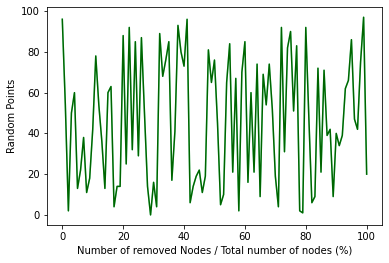

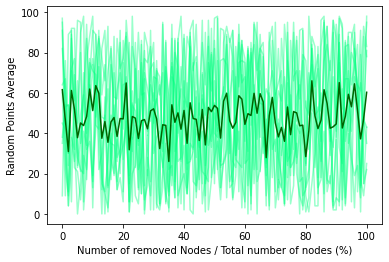

In [31]:
# MOCK DATA, HOW TO USE plot_lccs()

def _return_random_points(_=None):
  return list(np.random.randint(0,99, size=101))

# For one line
lccs = _return_random_points()
plot_lccs(lccs, 'Random Points')


# For averaging
a = [None] * 10
 
result = map(_return_random_points, a)
lccs = list(result)
 
plot_lccs(lccs, 'Random Points Average')

In [32]:
def refresh_metrics(graph,metrics):
  results_list = []

  for metric in metrics:
    centrality = metric(nx.Graph(graph))
    sorted_ = sorted(centrality.items(), key=lambda kv: kv[1])
    sorted_.reverse()
    results_list.append(sorted_)
  return results_list

def analyze_resilience(graph, metrics_names, batch_refresh=1, verbose=1):
  # TODO: refresh_metrics on batches

  one_pass = (batch_refresh == 1)

  batch_percent = graph.number_of_nodes()/100

  lccinit = lcc_size(graph)

  LCCs = []
  for _ in range(len(metrics_names)):
    LCCs.append([])
  densities = []
  for _ in range(len(metrics_names)):
    densities.append([])
  susceptibilities = []
  for _ in range(len(metrics_names)):
    susceptibilities.append([])

  graphs = []
  for _ in range(len(metrics_names)):
    graphs.append(deepcopy(graph))
  
  metrics = refresh_metrics(graph,metrics_names)

  init_N = graph.number_of_nodes()

  FOR_COND = tqdm.tqdm(range(0,init_N)) if verbose else range(0,init_N)
  for i in FOR_COND:
    if (i % (batch_refresh*init_N) == 0):
      if not one_pass:
        if verbose: print("--- updating metrics it [%d/%d] ---" % (i, init_N))
        for g, m, n in zip(graphs, metrics, metrics_names):
          m = refresh_metrics(g, [n])
    
    if int(i/batch_percent) != int(i/batch_percent + 1/batch_percent):
      for i, (g, m) in enumerate(zip(graphs, metrics)):
        LCCs[i].append(compute_resilience(g, lccinit))
        densities[i].append(nx.density(g))
        susceptibilities[i].append(susceptibility(g))
    
    for g, m in zip(graphs, metrics):
      pair = m.pop(0)
      g.remove_node(pair[0])
  
  for i, _ in enumerate(graphs):
    while len(LCCs[i]) < 101: LCCs[i].append(0)
    while len(densities[i]) < 101: densities[i].append(0)
    while len(susceptibilities[i]) < 101: susceptibilities[i].append(0)
  
  return LCCs, densities, susceptibilities

100%|██████████| 1138/1138 [00:02<00:00, 422.45it/s]


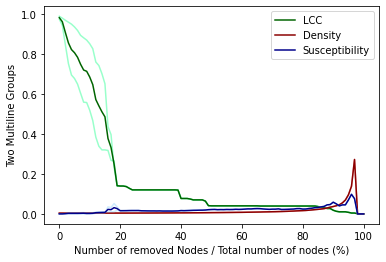

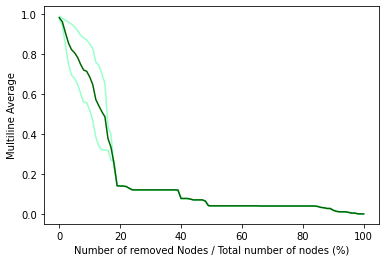

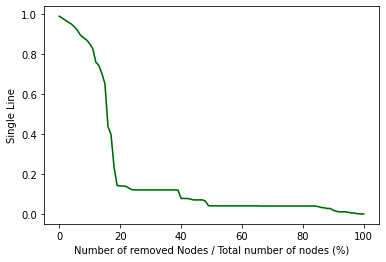

In [33]:
# TEST DATA, HOW TO USE analyze_resilience() and plot_LCCS()

graphs = er_graphs[:]
graph_test = g_power.copy()
LCCs, densities, susceptibilities = analyze_resilience(graph_test, [nx.clustering, nx.triangles])

l = [LCCs[i][0:101] for i in range(0,2)]
d = [densities[i][0:101] for i in range(0,2)]
s = [susceptibilities[i][0:101] for i in range(0,2)]

plot_lccs([l, d, s], 'Two Multiline Groups', labels=['LCC','Density','Susceptibility'])
plot_lccs(l, 'Multiline Average')
plot_lccs(l[0], 'Single Line')

#### Analysis and results of Random Networks

##### Comparing removal methods:


In this section, we will compare the efficacy of the different removal methods for all the random graphs. For this, we will plot their resilience values for every 1% of nodes removed, meaning that an earlier decrease is a more effective method.

In [53]:
def degree_wrapper(G):
  '''
  Wrapper to include nx.degree() as a removal method in analyze_resilience
  It needs to return a dictionary of the results per node
  '''
  return dict(nx.degree(G))

def pagerank_wrapper(G):
  '''
  Wrapper to include nx.pagerank() as a removal method in analyze_resilience
  Default 100 iterations gives 'power iteration failed to converge' error
  It needs to return a dictionary of the results per node
  '''
  return nx.pagerank(G, max_iter=750)
def eigenvector_wrapper(G):
  '''
  Wrapper to include nx.eigenvector_centrality() as a removal method in analyze_resilience
  Default 100 iterations gives 'power iteration failed to converge' error
  It needs to return a dictionary of the results per node
  '''
  return nx.eigenvector_centrality(G, max_iter=750)

def random_wrapper(G):
  '''
  Wrapper to include random choosing as a removal method in analyze_resilience
  It needs to return a dictionary of the results per node
  '''
  return {k: random.random() for k in range(G.number_of_nodes())}

###### Erdös-Rényi:

In [43]:
graphs = deepcopy(er_graphs)

removal_methods = [nx.clustering, nx.triangles, degree_wrapper, 
                   nx.betweenness_centrality, eigenvector_wrapper, pagerank_wrapper, random_wrapper]
removal_labels = ['Clustering', 'Triangles', 'Degree', 
                  'Betweenness', 'Eigenvector', 'PageRank', 'Random']

er_ls = []
er_ds = []
er_ss = []
for g in graphs:
  LCCs, densities, susceptibilities = analyze_resilience(g, removal_methods, verbose=0)
  er_ls.append(LCCs[0:101])
  er_ds.append(densities[0:101])
  er_ss.append(susceptibilities[0:101])

for i, (ls,ds,ss) in enumerate(zip(er_ls, er_ds, er_ss)):
  for j, (l,d,s) in enumerate(zip(ls,ds,ss)):
    er_ls[i][j] = l[0:101]
    er_ds[i][j] = d[0:101]
    er_ss[i][j] = s[0:101]

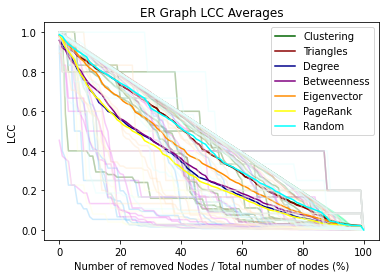

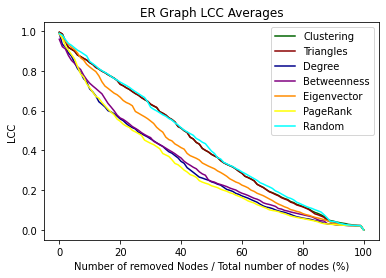

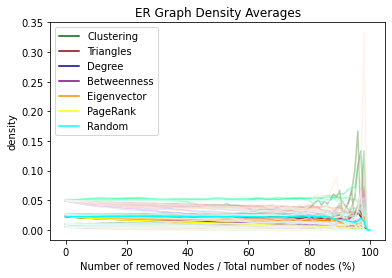

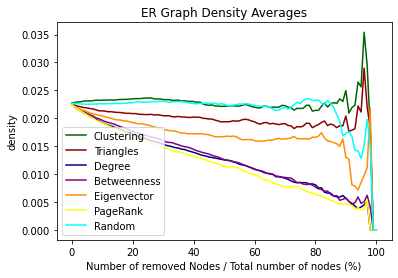

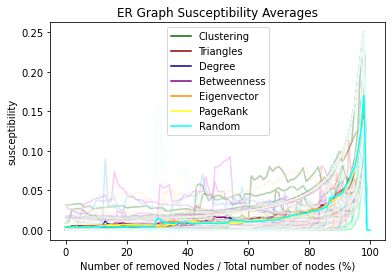

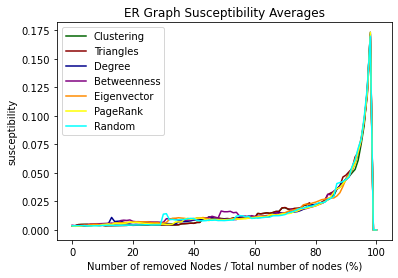

In [44]:
plot_lccs(np.einsum('kli->lki', np.array(er_ls)).tolist(), title='ER Graph LCC Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(er_ls)).tolist(), title='ER Graph LCC Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(er_ds)).tolist(), ylabel='density', title='ER Graph Density Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(er_ds)).tolist(), ylabel='density', title='ER Graph Density Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(er_ss)).tolist(), ylabel='susceptibility', title='ER Graph Susceptibility Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(er_ss)).tolist(), ylabel='susceptibility', title='ER Graph Susceptibility Averages', background_ticks=False, labels=removal_labels)

Although there is not much difference in LCC or susceptibility, we can see that PageRank, Degree and Betweenness centrality are the best methods. Note how after removing every node, the susceptibility dramatically goes back to zero. However, taking into consideration the previous computational cost, maybe we can decide that the most cost effective method that we could choose would be the degree or PageRank. Note also how the graph does not clearly break after a low percentage of nodes is removed. Let's see if this results are the same for the BA and WS models.

###### Barabási-Albert:

In [45]:
graphs = deepcopy(ba_graphs)

removal_methods = [nx.clustering, nx.triangles, degree_wrapper, 
                   nx.betweenness_centrality, eigenvector_wrapper, pagerank_wrapper, random_wrapper]
removal_labels = ['Clustering', 'Triangles', 'Degree', 
                  'Betweenness', 'Eigenvector', 'PageRank', 'Random']

ba_ls = []
ba_ds = []
ba_ss = []
for g in graphs:
  LCCs, densities, susceptibilities = analyze_resilience(g, removal_methods, verbose=0)
  ba_ls.append(LCCs[0:101])
  ba_ds.append(densities[0:101])
  ba_ss.append(susceptibilities[0:101])

for i, (ls,ds,ss) in enumerate(zip(ba_ls, ba_ds, ba_ss)):
  for j, (l,d,s) in enumerate(zip(ls,ds,ss)):
    ba_ls[i][j] = l[0:101]
    ba_ds[i][j] = d[0:101]
    ba_ss[i][j] = s[0:101]

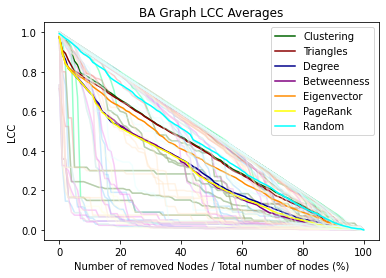

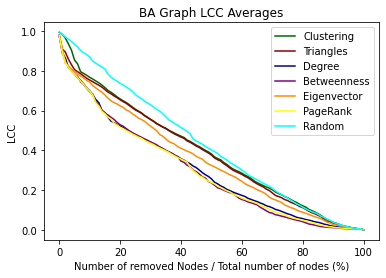

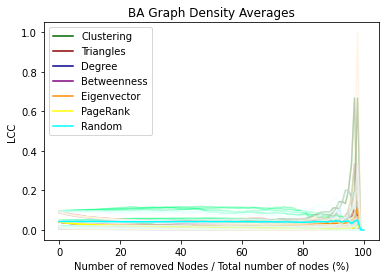

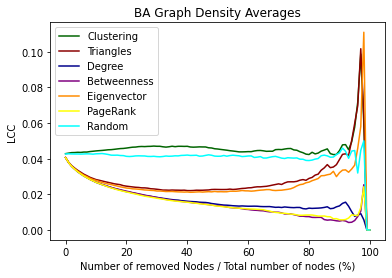

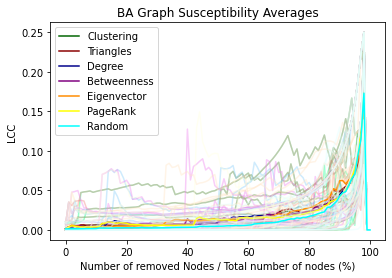

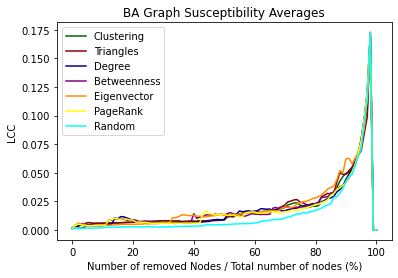

In [46]:
plot_lccs(np.einsum('kli->lki', np.array(ba_ls)).tolist(), title='BA Graph LCC Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ba_ls)).tolist(), title='BA Graph LCC Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ba_ds)).tolist(), title='BA Graph Density Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ba_ds)).tolist(), title='BA Graph Density Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ba_ss)).tolist(), title='BA Graph Susceptibility Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ba_ss)).tolist(), title='BA Graph Susceptibility Averages', background_ticks=False, labels=removal_labels)

###### Watts-Strogatz:

In [54]:
graphs = deepcopy(ws_graphs)

removal_methods = [nx.clustering, nx.triangles, degree_wrapper, 
                   nx.betweenness_centrality, random_wrapper]
removal_labels = ['Clustering', 'Triangles', 'Degree', 
                  'Betweenness', 'Random']

ws_ls = []
ws_ds = []
ws_ss = []
for g in graphs:
  LCCs, densities, susceptibilities = analyze_resilience(g, removal_methods, verbose=0)
  ws_ls.append(LCCs[0:101])
  ws_ds.append(densities[0:101])
  ws_ss.append(susceptibilities[0:101])

for i, (ls,ds,ss) in enumerate(zip(ws_ls, ws_ds, ws_ss)):
  for j, (l,d,s) in enumerate(zip(ls,ds,ss)):
    ws_ls[i][j] = l[0:101]
    ws_ds[i][j] = d[0:101]
    ws_ss[i][j] = s[0:101]

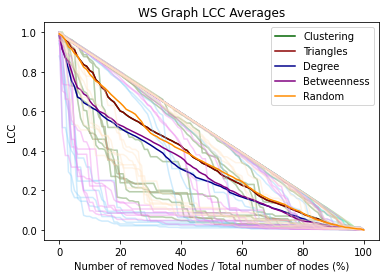

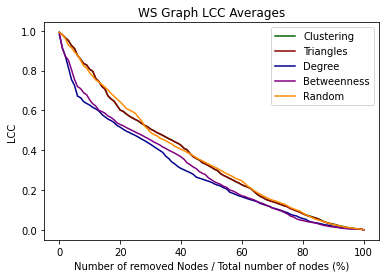

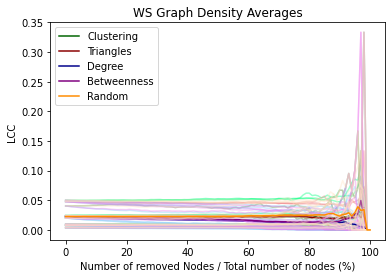

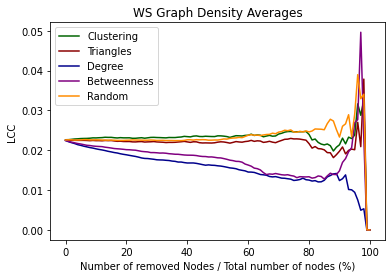

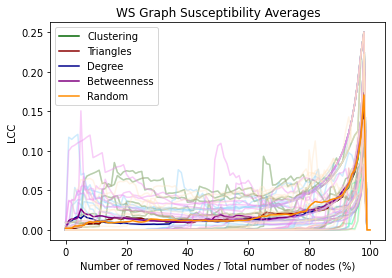

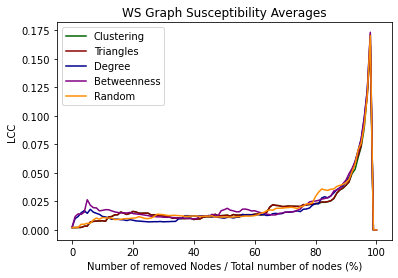

In [55]:
plot_lccs(np.einsum('kli->lki', np.array(ws_ls)).tolist(), title='WS Graph LCC Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ws_ls)).tolist(), title='WS Graph LCC Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ws_ds)).tolist(), title='WS Graph Density Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ws_ds)).tolist(), title='WS Graph Density Averages', background_ticks=False, labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ws_ss)).tolist(), title='WS Graph Susceptibility Averages', labels=removal_labels)
plot_lccs(np.einsum('kli->lki', np.array(ws_ss)).tolist(), title='WS Graph Susceptibility Averages', background_ticks=False, labels=removal_labels)

##### ER vs BA vs WS

Although we expected a bigger difference between the averages of the different graphs, expecting a higher decrease on the BA model, we can still see that they do not behave exactly the same.

In [56]:
er = deepcopy(er_graphs[0:10])
ba = deepcopy(ba_graphs[0:10])
ws = deepcopy(ws_graphs[0:10])

random_networks = {'er': { 'graphs': er }, 
                 'ba': { 'graphs': ba }, 
                 'ws': { 'graphs': ws } }

removal_methods = [degree_wrapper]
labels = ['ER', 'BA', 'WS']

for network_grid in random_networks:
  l = []
  d = []
  s = []
  for g in random_networks[network_grid]['graphs']:
    LCCs, densities, susceptibilities = analyze_resilience(g, removal_methods, verbose=0)

    l = l + [LCCs[i][0:101] for i in range(0,len(removal_methods))]
    d = d + [densities[i][0:101] for i in range(0,len(removal_methods))]
    s = s + [susceptibilities[i][0:101] for i in range(0,len(removal_methods))]

  random_networks[network_grid]['LCCs'] = l
  random_networks[network_grid]['densities'] = d
  random_networks[network_grid]['susceptibilities'] = s

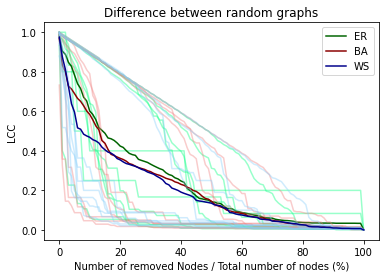

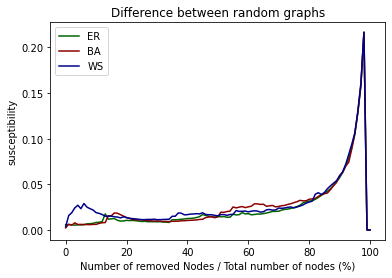

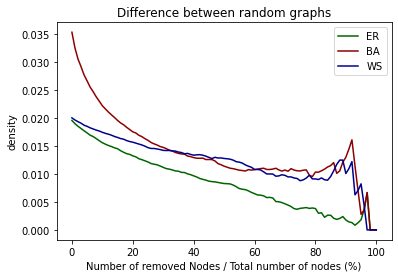

In [57]:
plot_lccs([random_networks['er']['LCCs'], random_networks['ba']['LCCs'], random_networks['ws']['LCCs']], 
          background_ticks=True, title='Difference between random graphs', labels=labels)
plot_lccs([random_networks['er']['susceptibilities'], random_networks['ba']['susceptibilities'], random_networks['ws']['susceptibilities']], 
          ylabel='susceptibility', background_ticks=False, title='Difference between random graphs', labels=labels)
plot_lccs([random_networks['er']['densities'], random_networks['ba']['densities'], random_networks['ws']['densities']], 
          ylabel='density', background_ticks=False, title='Difference between random graphs', labels=labels)

##### How does resilience change based on the hyperparameters



A more connection probability on any of the mentioned models will surely make the network more resilient. Does this happen increasing the number of nodes, too? Plotting a grid with the resilience values of each of the graphs we can check wether both parameters make the resilience line to converge to a linear decrease.

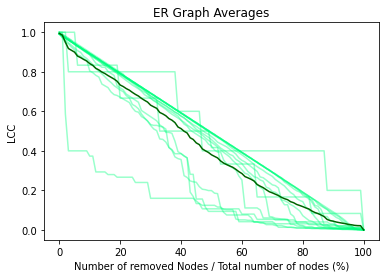

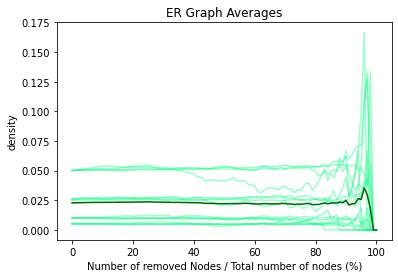

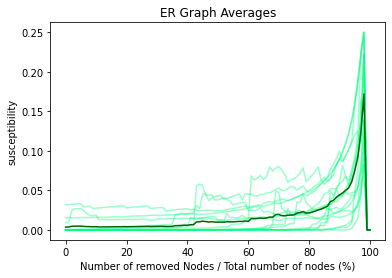

In [58]:
graphs = deepcopy(er_graphs)
graph_test = graphs[12]

ls = []
ds = []
ss = []
for g in graphs:
  LCCs, densities, susceptibilities = analyze_resilience(g, [nx.clustering], verbose=0)
  ls.append(LCCs[0][0:101])
  ds.append(densities[0][0:101])
  ss.append(susceptibilities[0][0:101])

a = [0.005, 0.01, 0.025, 0.05]

'''
for i in range(0,len(er_graphs)):
  print()
  print(i)
  print("Number of nodes:",nx.number_of_nodes(er_graphs[i]))
  print("p",a[i%4])
  plot_lccs(ss[i],title="p="+str(a[i%4])+" n="+str(nx.number_of_nodes(er_graphs[i])), labels=['Susceptibility'])
'''

plot_lccs(ls,title='ER Graph Averages', labels=['LCC','Density','Susceptibility'])
plot_lccs(ds,title='ER Graph Averages', ylabel='density', labels=['LCC','Density','Susceptibility'])
plot_lccs(ss,title='ER Graph Averages', ylabel='susceptibility', labels=['LCC','Density','Susceptibility'])

We can see that both the LCC and susceptibility are affected by the number of nodes and by the connection probability. This means that a
bigger random graph will be more resilient, and a graph with more connections too.

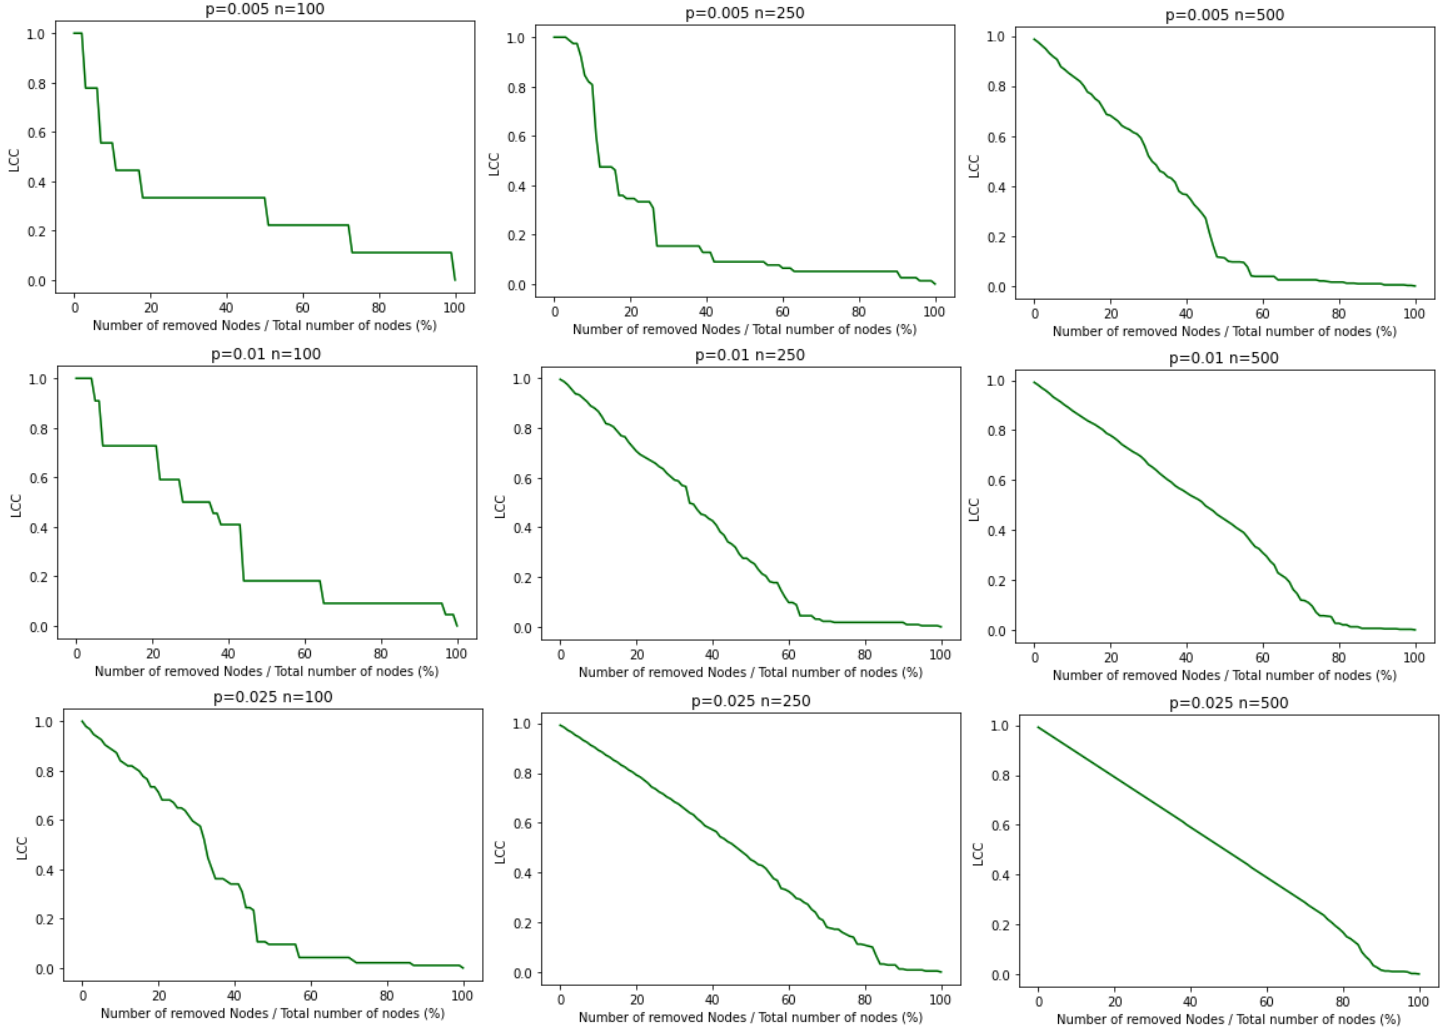

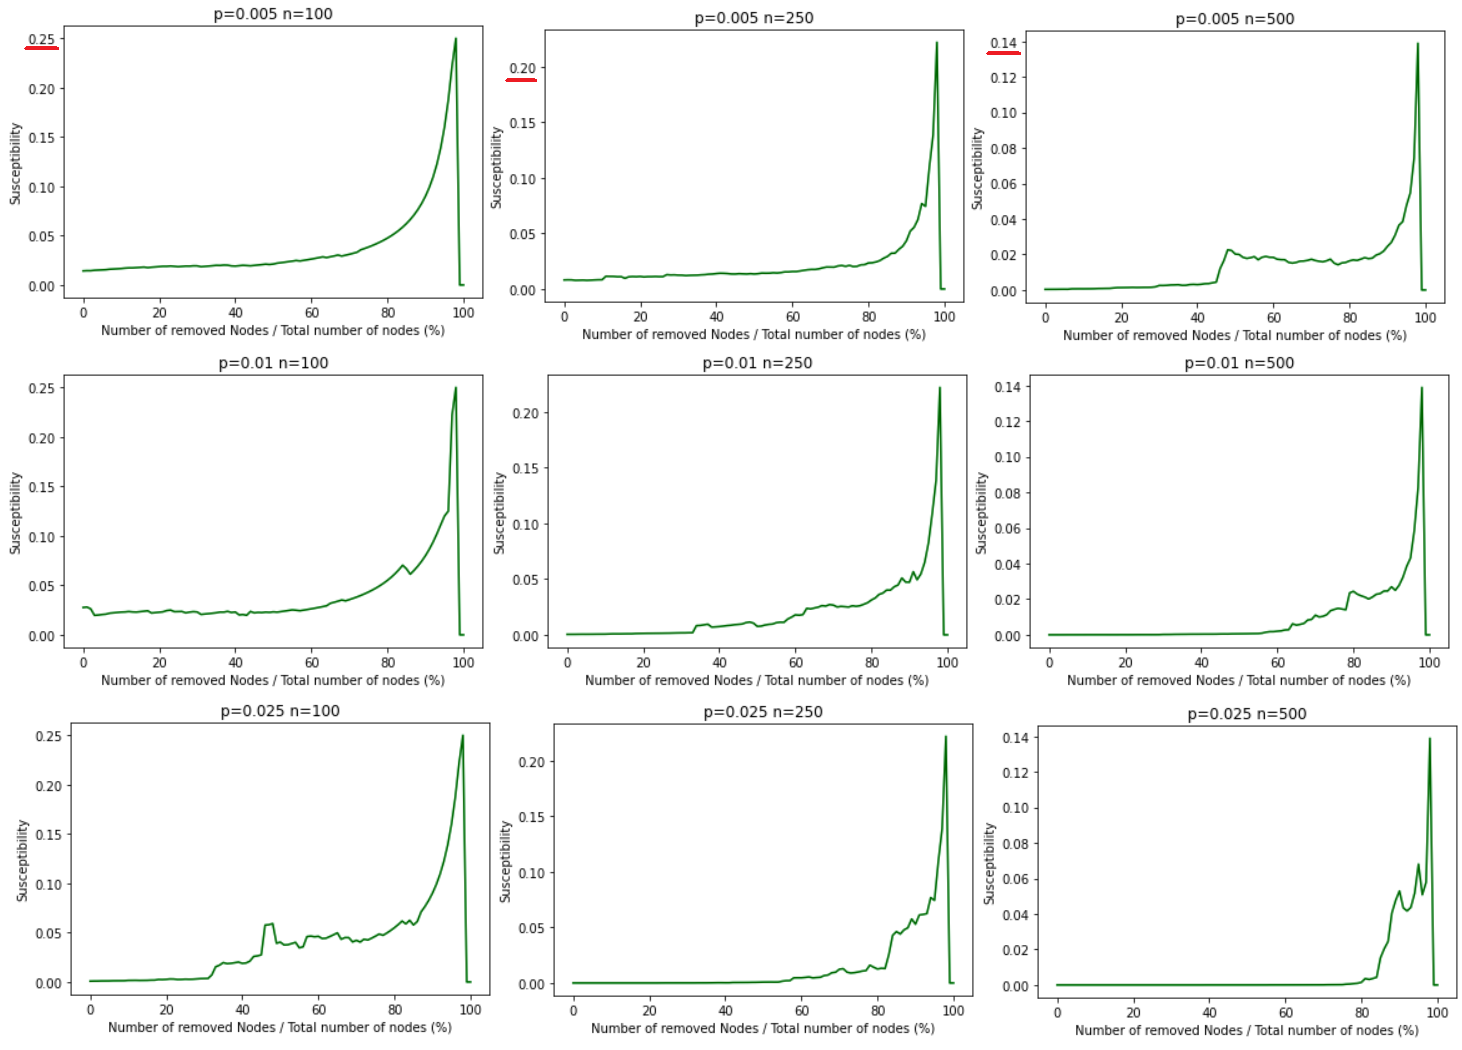

If we plot the average value for the ER graphs, we can see variance between the lower and the higher hyperparameter values.

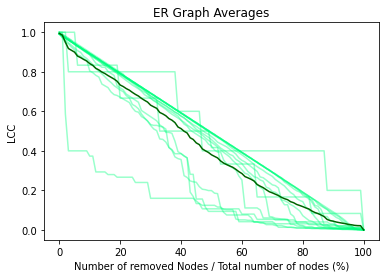

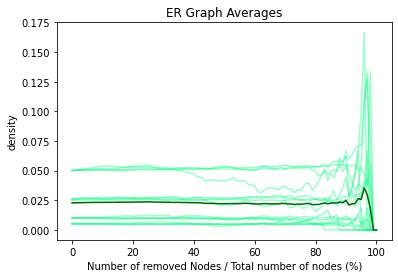

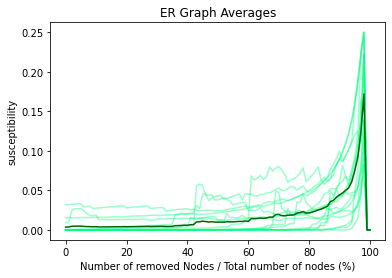

In [59]:
plot_lccs(ls,title='ER Graph Averages', labels=['LCC','Density','Susceptibility'])
plot_lccs(ds,title='ER Graph Averages', ylabel='density', labels=['LCC','Density','Susceptibility'])
plot_lccs(ss,title='ER Graph Averages', ylabel='susceptibility', labels=['LCC','Density','Susceptibility'])

#### Analysis and results of Real Networks

##### Generate complete history for every real network for later visual representation

In [60]:
real_networks = {'drosophilia': { 'graph': g_drosophilia }, 
                 'gnutella': { 'graph': g_gnutella }, 
                 'openflights': { 'graph': g_openflights }, 
                 'power': { 'graph': g_power },
                 'roads_minnesota': { 'graph': g_roads_minnesota } }

removal_methods = [nx.clustering, nx.triangles, degree_wrapper, nx.betweenness_centrality]
removal_labels = ['Clustering', 'Triangles', 'Degree', 'Betweenness']

for network in real_networks:
  LCCs, densities, susceptibilities = analyze_resilience(deepcopy(real_networks[network]['graph']), removal_methods, verbose=0)

  l = [LCCs[i][0:101] for i in range(0,len(removal_methods))]
  d = [densities[i][0:101] for i in range(0,len(removal_methods))]
  s = [susceptibilities[i][0:101] for i in range(0,len(removal_methods))]

  real_networks[network]['LCC'] = l
  real_networks[network]['density'] = d
  real_networks[network]['susceptibility'] = s

##### Comparing removal methods:

In this section, we will compare the efficacy of the different removal methods for all the selected real networks. For this, we will plot their resilience values for every 1% of nodes removed, meaning that an earlier decrease is a more effective method. It is important to note that, due to memory reasons, we could not use any power iteration methods such as PageRank or eigenvalues centrality on these larger networks, so they are out of the analysis.  
For this analysis we are separately plotting the resilience values of each of the networks.

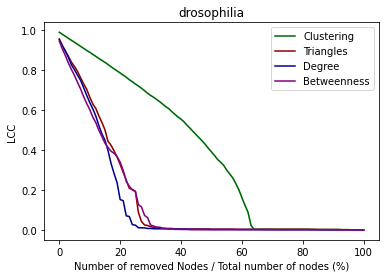

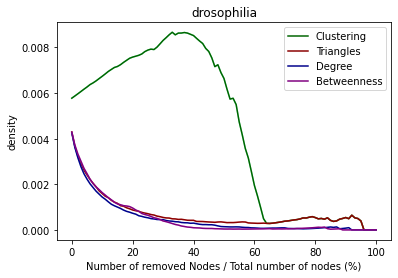

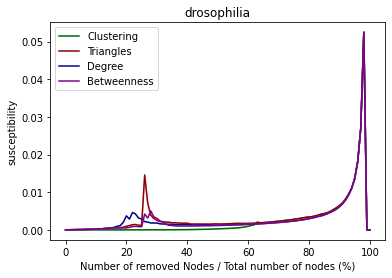

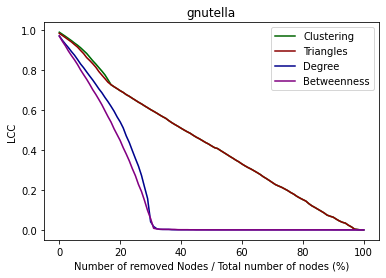

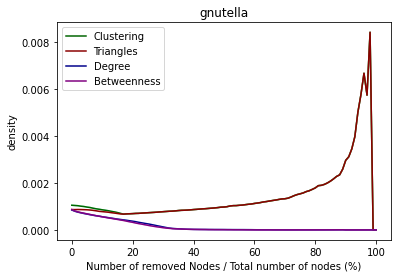

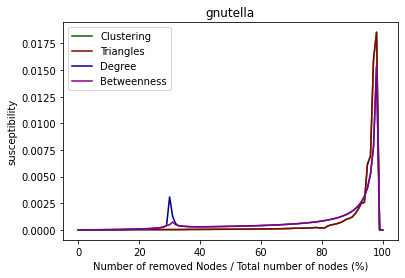

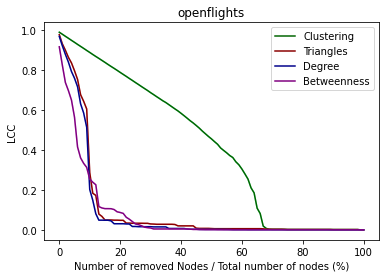

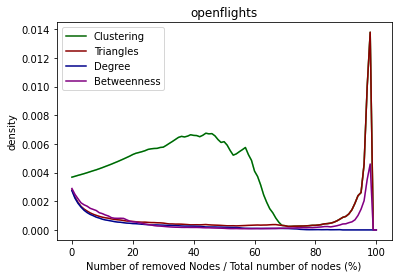

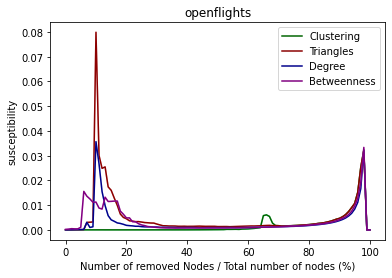

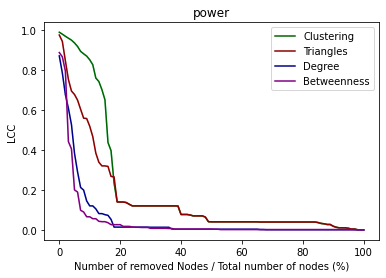

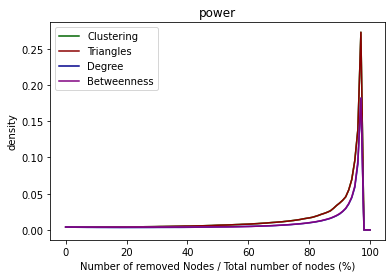

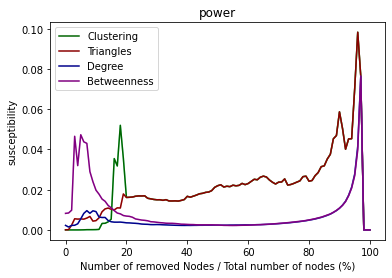

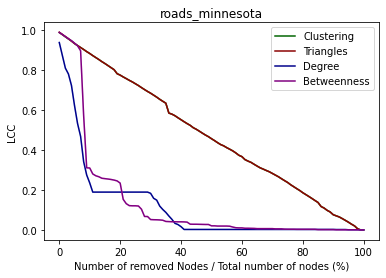

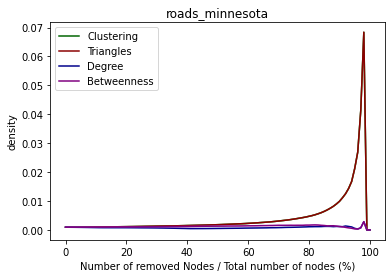

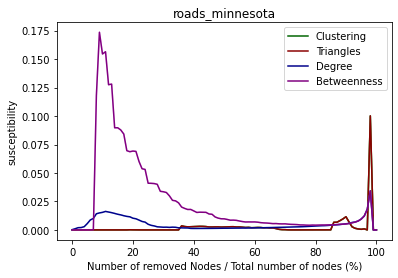

In [61]:
for network in real_networks:
  l = real_networks[network]['LCC']
  d = real_networks[network]['density']
  s = real_networks[network]['susceptibility']

  plot_lccs([[l[0]], [l[1]], [l[2]], [l[3]]], title=network, labels=removal_labels)
  plot_lccs([[d[0]], [d[1]], [d[2]], [d[3]]], ylabel='density', title=network, labels=removal_labels)
  plot_lccs([[s[0]], [s[1]], [s[2]], [s[3]]], ylabel='susceptibility', title=network, labels=removal_labels)

The best methods seem to be the degree and betweenness centrality. Note how we would probably prefer the degree in this case, as it is many orders of magnitude faster than the betweenness centrality. As opposed to the random networks, we can see a clear breaking point when we remove around the first 10% of the nodes.

##### Comparing resilience between networks:

Another interesting comparison is which of the networks has a better resilience in their structure. For this, we will plot the average values for each of the networks and compare them. A network whose graph is more similar to a linear decrease will be more resilient, and those that experience a bigger decrease earlier on the graph will be more susceptible to any perturbations.

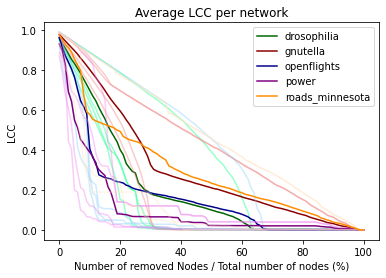

In [62]:
ls = []
for network in real_networks:
  ls.append(real_networks[network]['LCC'])

plot_lccs(ls, title='Average LCC per network', labels=list(real_networks.keys()))

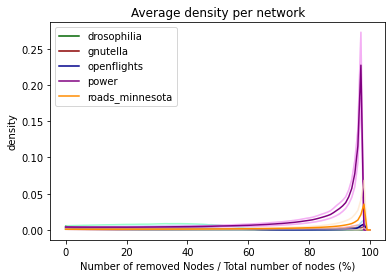

In [63]:
ds = []
for network in real_networks:
  ds.append(real_networks[network]['density'])

plot_lccs(ds, title='Average density per network', ylabel='density', labels=list(real_networks.keys()))

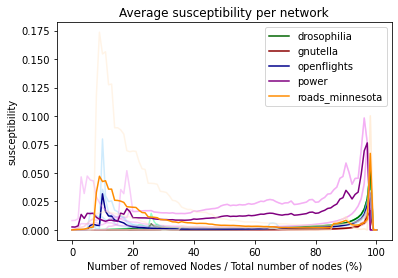

In [64]:
ss = []
for network in real_networks:
  ss.append(real_networks[network]['susceptibility'])

plot_lccs(ss, title='Average susceptibility per network', ylabel='susceptibility', labels=list(real_networks.keys()))

As we can see, Gnutella, as a sample of internet peer-to-peer, is the most resilient network. The power grid network is the one that suffers
the most. This makes sense, as electric infrastructure is an expensive and complicated task in which we cannot have as many bigger nodes as we want due to diverse factors.

#### **Note**: One-pass vs Batch update
Is there any difference between updating the node list in batches during the removal process in a static context, or will the order not change?

In [65]:
G = nx.erdos_renyi_graph(190, 0.01, seed=SEED)

In [66]:
LCCs, densities, susceptibilities = analyze_resilience(G, [degree_wrapper], verbose=0)
LCCs_batch, densities_batch, susceptibilities_batch = analyze_resilience(G, [degree_wrapper], 0.1, verbose=0)

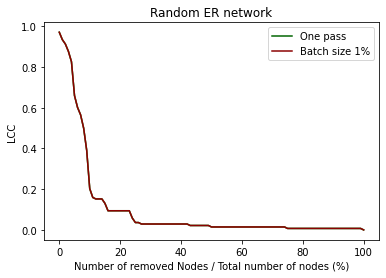

In [67]:
plot_lccs([[LCCs[0]], [LCCs_batch[0]]], title='Random ER network', labels=['One pass','Batch size 1%'])

In [68]:
LCCs[0] == LCCs_batch[0]

True

In [69]:
LCCs, densities, susceptibilities = analyze_resilience(g_power, [degree_wrapper], verbose=0)
LCCs_batch, densities_batch, susceptibilities_batch = analyze_resilience(g_power, [degree_wrapper], 0.01, verbose=0)

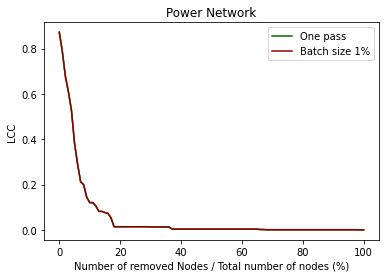

In [70]:
plot_lccs([[LCCs[0]], [LCCs_batch[0]]], title='Power Network', labels=['One pass','Batch size 1%'])

In [71]:
LCCs[0] == LCCs_batch[0]

True

As we have seen, for any kind of static networks none of the chosen metrics benefit from updating the removal order in real time. In this case, we check that an update batch size of 1%, meaning that the list gets updated with new metrics after every 1% of the nodes is removed, take identical values of LCC for both random and real networks.